In [3]:
import argparse
import torch
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertTokenizer
import numpy as np
import torch.nn.functional as F

from sampler.SequenceEnergy import SequenceEnergy
from sampler.HMCSampler import HMCSampler

device = "cuda"

# GPT2 Model and Tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Lookup table: token IDs into token embeddings
embed_lut = model.get_input_embeddings()

# Prompt 
prompt = "The movie was"

# Token ids for Prompt
prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# Token ids for tokens generated by model (Excluding prompt)
output_ids = model.generate(prompt_ids, max_length=23, do_sample=True, temperature=0.7, top_k=50)[0, len(prompt_ids[0]):]

# Token embeddings of output sequence (Excluding prompt)
Y = embed_lut(output_ids).unsqueeze(0)  # [1, 20, 768]

# Initial sentence generated by model
decoded_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(f"Initial sentence: {decoded_text}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Initial sentence:  released on October 5, 2015 and was released in the US on October 7, 2015. The story


In [4]:

# initialize the target sentiment embedding
e_positive = embed_lut(tokenizer.encode("good", return_tensors="pt")[0].to(device)).mean(dim=0)

# initialize the target sentiment embedding
e_bad = embed_lut(tokenizer.encode("bad", return_tensors="pt")[0].to(device)).mean(dim=0)

In [5]:
print(e_positive)

tensor([ 0.0302, -0.0152,  0.0008, -0.2883,  0.0010,  0.0072, -0.2818, -0.0909,
        -0.0118, -0.1821,  0.0332,  0.0587, -0.0434, -0.0858,  0.1166,  0.0722,
         0.1277,  0.0350,  0.0883,  0.1303,  0.0890, -0.0519,  0.0464, -0.1045,
        -0.1304, -0.0914,  0.1292, -0.0033, -0.0415,  0.1094, -0.0225, -0.1346,
         0.1382,  0.1586,  0.0775,  0.0502, -0.3193, -0.0972,  0.0851,  0.1168,
         0.1131,  0.0081, -0.2475, -0.0891, -0.0982,  0.0317, -0.0198, -0.2333,
        -0.0307, -0.1363,  0.1541,  0.0014,  0.0661, -0.0560,  0.1755, -0.2025,
        -0.0708, -0.1350,  0.0608, -0.0870, -0.1399, -0.0278, -0.2187,  0.0680,
         0.1496, -0.0321, -0.0369, -0.0935,  0.3257,  0.0118, -0.0361, -0.0613,
        -0.0949,  0.0458,  0.3183,  0.2743, -0.1024,  0.2306,  0.0439,  0.0976,
         0.0374,  0.1156,  0.1168,  0.1110,  0.1965,  0.0981, -0.1395,  0.1145,
         0.0599, -0.0694, -0.3483,  0.2647,  0.1844, -0.1277,  0.1719, -0.0275,
        -0.1162, -0.0166,  0.0312,  0.14

In [6]:
print(e_bad)

tensor([ 5.3869e-02,  9.0844e-02,  1.4706e-01, -1.5967e-01,  7.5559e-02,
         1.8405e-01, -2.9929e-01, -1.3042e-01,  1.2473e-01, -1.8882e-01,
        -4.9020e-02, -6.8902e-02, -7.3467e-02,  2.1969e-02, -1.2159e-02,
        -3.6007e-01,  3.7603e-02,  1.2515e-01,  5.5841e-02,  1.9321e-01,
         1.1469e-01, -2.0701e-01,  6.7399e-02, -7.8243e-02, -5.6723e-02,
         1.0915e-01,  1.4279e-02,  3.3783e-02, -1.2788e-01, -3.8454e-02,
         1.0312e-01, -3.9572e-02,  3.7554e-02,  1.0236e-01,  2.5227e-02,
        -8.6389e-02, -3.1933e-01,  6.4479e-02,  5.8307e-02, -5.7049e-02,
         2.3665e-01,  7.2045e-02, -2.0451e-01, -2.4764e-01, -1.8143e-01,
         6.6913e-02,  1.2172e-01, -3.9466e-01,  1.6711e-01, -5.9356e-02,
         1.3649e-01,  3.7382e-02, -4.7924e-02,  6.0199e-02, -2.2588e-02,
        -2.4158e-01,  8.5920e-03, -6.2090e-02,  7.5134e-02,  1.6017e-01,
        -4.3138e-02, -1.0998e-01, -1.9367e-01,  2.4006e-01,  2.2384e-01,
         2.1269e-01, -1.4994e-01, -5.0437e-02,  2.2

In [43]:
e_positive = e_positive.unsqueeze(0).unsqueeze(0)
print(e_positive.shape)
e_bad = e_bad.unsqueeze(0).unsqueeze(0)
print(e_bad.shape)

torch.Size([1, 1, 768])
torch.Size([1, 1, 768])


In [44]:
def get_projected_tokens(embeddings, embed_lut):
        """
        Project embeddings to token IDs.
        
        Returns:
            token_ids: Tensor [batch_size, sent_length]
        """
        scores = torch.cdist(embeddings.view(-1, embeddings.size(-1)), embed_lut.weight)
        return scores.argmin(dim=-1).view(embeddings.size(0), -1)

In [45]:
positive_token_ids = get_projected_tokens(e_positive, embed_lut)
negative_token_ids = get_projected_tokens(e_bad, embed_lut)

In [46]:
print(positive_token_ids.squeeze(0).squeeze(0))
print(negative_token_ids.squeeze(0).squeeze(0))

tensor(11274, device='cuda:0')
tensor(14774, device='cuda:0')


In [47]:
projected_tokens = tokenizer.convert_ids_to_tokens(positive_token_ids.squeeze(0))
neg_projected_tokens = tokenizer.convert_ids_to_tokens(negative_token_ids.squeeze(0))

In [48]:
print(projected_tokens)
print(neg_projected_tokens)

['good']
['bad']


In [53]:
def sentiment_score(embeddings, e_target):
    # Normalize both inputs
    normalized_embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
    normalized_target = torch.nn.functional.normalize(e_target, dim=-1)
    
    # Compute dot product
    return torch.sum(normalized_embeddings * normalized_target, dim=-1)

In [58]:
def sentiment_score2(embeddings, e_target):
    # Compute dot product
    return torch.sum(embeddings * e_target, dim=-1)

In [ ]:
print()

In [77]:

# initialize the target sentiment embedding
e_positive = embed_lut(tokenizer.encode("good love lovely positive amazing joy success wonderful fantastic happy joyful optimistic hopeful successful kind loving brave caring compassionate inspired confident enthusiastic grateful generous friendly bright peaceful wonderful supportive motivated honest trustworthy respectful talented creative excited productive determined strong achieving radiant fulfilled gentle patient courageous content positive peaceful harmonious", return_tensors="pt")[0].to(device)).mean(dim=0)

# initialize the target sentiment embedding
e_bad = embed_lut(tokenizer.encode("bad", return_tensors="pt")[0].to(device)).mean(dim=0)
e_bad1 = embed_lut(tokenizer.encode("worst", return_tensors="pt")[0].to(device)).mean(dim=0)
e_bad2 = embed_lut(tokenizer.encode("disgust", return_tensors="pt")[0].to(device)).mean(dim=0)
e_bad3 = embed_lut(tokenizer.encode("awful", return_tensors="pt")[0].to(device)).mean(dim=0)
e_positive2 = embed_lut(tokenizer.encode("happy", return_tensors="pt")[0].to(device)).mean(dim=0)
e_positive3 = embed_lut(tokenizer.encode("great", return_tensors="pt")[0].to(device)).mean(dim=0)
e_positive4 = embed_lut(tokenizer.encode("excellent", return_tensors="pt")[0].to(device)).mean(dim=0)


print(sentiment_score(e_positive, e_bad))
print(sentiment_score(e_positive, e_bad1))
print(sentiment_score(e_positive, e_bad2))
print(sentiment_score(e_positive, e_bad3))
print()

# Additional negative sentiment words
e_negative4 = embed_lut(tokenizer.encode("horrendous", return_tensors="pt")[0].to(device)).mean(dim=0)
e_negative5 = embed_lut(tokenizer.encode("terrible", return_tensors="pt")[0].to(device)).mean(dim=0)
e_negative6 = embed_lut(tokenizer.encode("pathetic", return_tensors="pt")[0].to(device)).mean(dim=0)
e_negative7 = embed_lut(tokenizer.encode("disappointing", return_tensors="pt")[0].to(device)).mean(dim=0)

# Additional positive sentiment words
e_positive5 = embed_lut(tokenizer.encode("outstanding", return_tensors="pt")[0].to(device)).mean(dim=0)
e_positive6 = embed_lut(tokenizer.encode("brilliant", return_tensors="pt")[0].to(device)).mean(dim=0)
e_positive7 = embed_lut(tokenizer.encode("spectacular", return_tensors="pt")[0].to(device)).mean(dim=0)
e_positive8 = embed_lut(tokenizer.encode("remarkable", return_tensors="pt")[0].to(device)).mean(dim=0)

print("Comparing e_positive with more negative words:")
print(sentiment_score(e_positive, e_negative4))  # Should be low
print(sentiment_score(e_positive, e_negative5))  # Should be low
print(sentiment_score(e_positive, e_negative6))  # Should be low
print(sentiment_score(e_positive, e_negative7))  # Should be low
print()

print("Comparing e_positive with more positive words:")
print(sentiment_score(e_positive, e_positive5))  # Should be high
print(sentiment_score(e_positive, e_positive6))  # Should be high
print(sentiment_score(e_positive, e_positive7))  # Should be high
print(sentiment_score(e_positive, e_positive8))  # Should be high
print()

print("Comparing strong positive words with strong negative words:")
print(sentiment_score(e_positive5, e_negative4))  # Should be low
print(sentiment_score(e_positive6, e_negative5))  # Should be low
print(sentiment_score(e_positive7, e_negative6))  # Should be low
print(sentiment_score(e_positive8, e_negative7))  # Should be low
print()


tensor(0.4368, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.4662, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5368, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.4869, device='cuda:0', grad_fn=<SumBackward1>)

Comparing e_positive with more negative words:
tensor(0.5303, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5178, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5385, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5667, device='cuda:0', grad_fn=<SumBackward1>)

Comparing e_positive with more positive words:
tensor(0.4862, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5556, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5206, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5702, device='cuda:0', grad_fn=<SumBackward1>)

Comparing strong positive words with strong negative words:
tensor(0.4264, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.4566, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.4216, device='cuda:0', grad_fn=<SumBackward1>)
ten

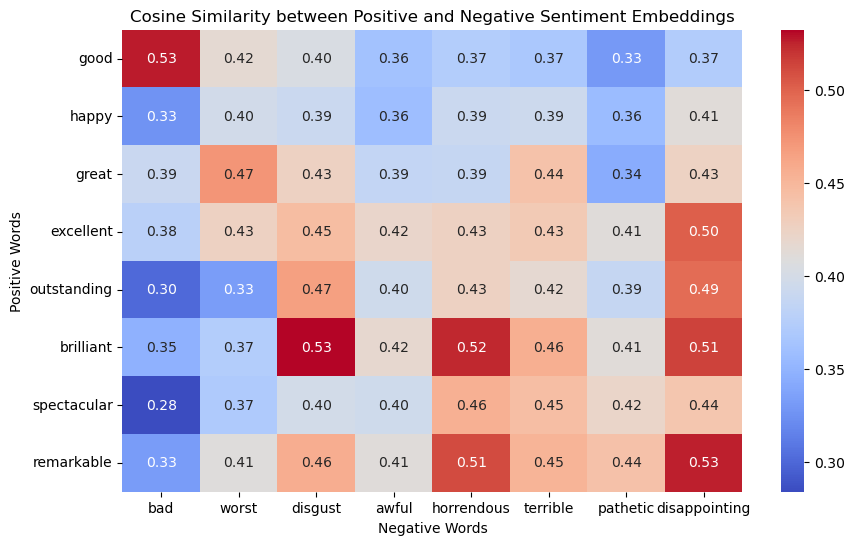

In [78]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define sentiment words and embeddings
positive_words = ["good", "happy", "great", "excellent", "outstanding", "brilliant", "spectacular", "remarkable"]
negative_words = ["bad", "worst", "disgust", "awful", "horrendous", "terrible", "pathetic", "disappointing"]

# Encode words and compute embeddings
positive_embeddings = [embed_lut(tokenizer.encode(word, return_tensors="pt")[0].to(device)).mean(dim=0) for word in positive_words]
negative_embeddings = [embed_lut(tokenizer.encode(word, return_tensors="pt")[0].to(device)).mean(dim=0) for word in negative_words]

# Compute similarity scores (cosine similarity)
similarity_matrix = np.zeros((len(positive_words), len(negative_words)))

for i, e_pos in enumerate(positive_embeddings):
    for j, e_neg in enumerate(negative_embeddings):
        similarity_matrix[i, j] = torch.nn.functional.cosine_similarity(e_pos.unsqueeze(0), e_neg.unsqueeze(0)).item()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=negative_words, yticklabels=positive_words, cmap="coolwarm", fmt=".2f")
plt.xlabel("Negative Words")
plt.ylabel("Positive Words")
plt.title("Cosine Similarity between Positive and Negative Sentiment Embeddings")
plt.show()


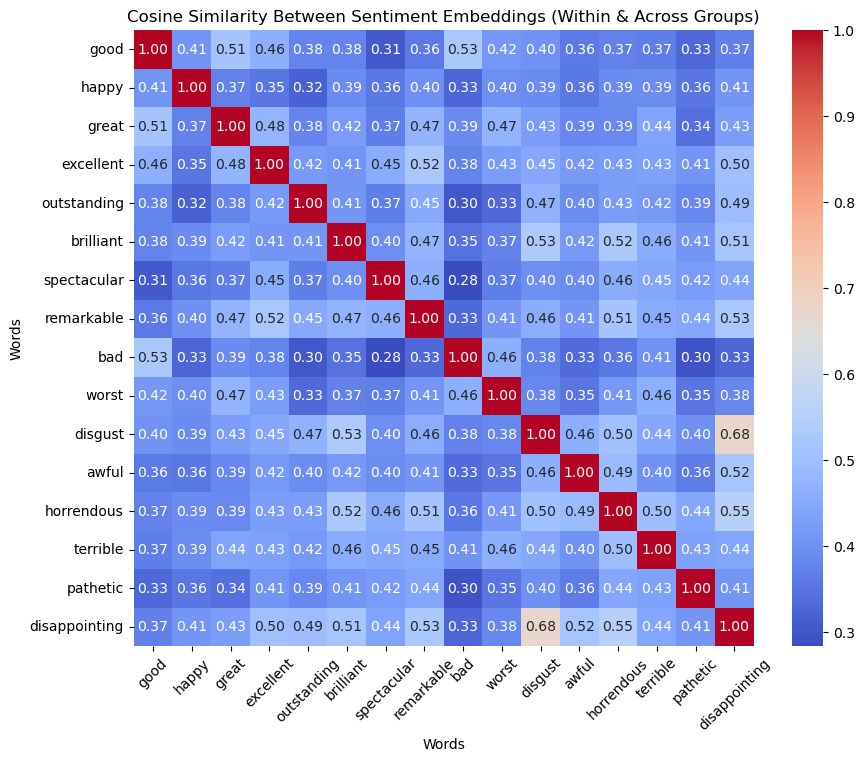

In [79]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define positive and negative sentiment words
positive_words = ["good", "happy", "great", "excellent", "outstanding", "brilliant", "spectacular", "remarkable"]
negative_words = ["bad", "worst", "disgust", "awful", "horrendous", "terrible", "pathetic", "disappointing"]

# Combine words for unified visualization
all_words = positive_words + negative_words

# Encode words and compute embeddings
all_embeddings = [embed_lut(tokenizer.encode(word, return_tensors="pt")[0].to(device)).mean(dim=0) for word in all_words]

# Compute similarity scores (cosine similarity)
num_words = len(all_words)
similarity_matrix = np.zeros((num_words, num_words))

for i in range(num_words):
    for j in range(num_words):
        similarity_matrix[i, j] = torch.nn.functional.cosine_similarity(
            all_embeddings[i].unsqueeze(0), all_embeddings[j].unsqueeze(0)
        ).item()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, xticklabels=all_words, yticklabels=all_words, cmap="coolwarm", fmt=".2f")
plt.xlabel("Words")
plt.ylabel("Words")
plt.title("Cosine Similarity Between Sentiment Embeddings (Within & Across Groups)")
plt.xticks(rotation=45)
plt.show()


In [1]:
''' 

'''
import torch 
import numpy as np
from util import *
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertTokenizer


DEBUG_ACCEPT = False


class HMCSampler:
    
    # sequence_embeddings = embeddings of the output tokens
    def __init__(self, sequence_energy, rng, device, alpha=0.1, debug=False, log_file_name='log_data/sample_log'):
        self.sequence_energy = sequence_energy
        
        self.rng = rng

        self.alpha = alpha
        
        self.device = device

        self.debug = debug

        self.lambda_grad = 0.0

        self.file_name = log_file_name

        print(debug)

    def get_sampled_velocities(self, stddv):
        """
        Sample random velocities from zero-mean Gaussian for all parameters.
        

        Parameters
        ----------
        stddv : float32
            standard deviation for all parameters sampling.

        Returns
        -------
        velocities : list of tensors with the same shape as each shape in self.shape sampled velocities for all parameters.

        """
        return torch.normal(mean=0, std=stddv, size=self.sequence_energy.embeddings.size(), device=self.device)
        
    
    def leapfrog(self, velocities, delta, /, *ARGS):
        """
        In-place leapfrog iteration.
        It should update `list(self.model.parameters())` as position $x$ in
        HMC.
        It should update `velocities` as momentum $p$ in HMC.
        

        Parameters
        ----------
        velocities : list of length(self.shapes), float32
            sampled velocities for all parameters.
        delta : float32
            delta in HMC algorithm.
        *ARGS : (X, y, y_1hot) as described in utils.py and NeuralNetwork model learning
            
        Returns
        -------
        velocities : list of length(self.shapes), float32
            leapfrog updated velocities for all parameters.

        """

        # Half-step update for velocities
        emb_grad, lambda_grad = self.sequence_energy.compute_gradients()

        '''
        emb_grad:           torch.Size([1, 20, 768])
        lambda_grad:        scalar value
        velocities:         torch.Size [1, 20, 768]
        embeddings:         torch.Size([1, 20, 768])
        '''

        # DEBUG
        # if self.debug:
        #     print(f"emb_grad shape: {emb_grad.shape}")
        #     print(f"lambda_grad shape: {lambda_grad.shape}")
        #     print(f"lambda_grad: {lambda_grad}")
        #     print(f"velocities len: {velocities.shape}")
        #     print(f"self.sequence_energy.embeddings shape : {self.sequence_energy.embeddings.shape}")

        # Remove batch dimension
        emb_grad = emb_grad.squeeze(0)

        # Half step update for velocity / lambda update
        velocities_half = velocities - 0.5 * delta * emb_grad
        # new_lambda = self.sequence_energy.lambda_energy + 0.5 * self.alpha * lambda_grad # right?

        # Full-step update for embeddings
        self.sequence_energy.embeddings = (
            self.sequence_energy.embeddings + delta * velocities_half
        ).detach().clone().requires_grad_() 
        # reset lambda to remove from graph
        self.sequence_energy.lambda_energy = self.sequence_energy.lambda_energy.detach().clone().requires_grad_()

        # Another half-step update for velocities
        emb_grad, lambda_grad = self.sequence_energy.compute_gradients()

        # save it for adaptive update
        self.lambda_grad = lambda_grad

        emb_grad = emb_grad.squeeze(0)

        # Half step update for velocity / lambda update
        velocities = velocities_half - 0.5 * delta * emb_grad
        # new_lambda = new_lambda + 0.5 * self.alpha * lambda_grad # right?
        # self.sequence_energy.lambda_energy.data = torch.tensor(max(new_lambda, 0), dtype=torch.float32, device=self.sequence_energy.device)

        return velocities
        
        

    def accept_or_reject(self, potential_energy_previous, potential_energy_current, 
                         kinetic_energy_previous, kinetic_energy_current):
        """
        Given the potential and kinetic energies  of the last sample and new sample, 
        check if we should accept new sample.
        If True, we will accept new sample.
        If False, we will reject new sample, and repeat the last sample.
        

        Parameters
        ----------
        potential_energy_previous : float32
            potential energy of last sample.
        potential_energy_current : float32
            potential energy of new sample.
        kinetic_energy_previous : float32
            kinetic energy of last sample.
        kinetic_energy_current : float32
            kinetic energy of new sample.

        Returns
        -------
        boolean
            True if to accept, False if to reject.

        """
        
        alpha = min(1, torch.exp(potential_energy_previous + kinetic_energy_previous - potential_energy_current - kinetic_energy_current))
        if np.random.uniform(low=0, high=1) <= alpha:
            return True, alpha
        else:
            return False, alpha
        
        # raise NotImplementedError("Complete Implementation")
    
    def sample(self, n, std_dev, delta_start, num_leapfrogs, /, *ARGS):
        """
        Sample from given parameters using Hamiltonian Monte Carlo.
        

        Parameters
        ----------
        n : int
            number of samples to generate.
        std_dev : float32
            standard deviation for sampling velocities.
        delta : float32
            delta in sampling velocities as in ALgorithm.
        num_leapfrogs : int
            number of leapfrog steps to do.
        *ARGS : (X, y, y_1hot) as described in utils.py and NeuralNetwork model learning
            
        Returns
        -------
        samples : list of length (1 + n), comprising of list of samples (model parameters) of length (self.model.shapes)
            initial and generated samples of model parameters.

        """
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # debugging TODO

        n = int(n)

        # Initialize buffer.
        samples = []
        potentials = []

        samples.append(self.sequence_energy.embeddings)

        with torch.no_grad():  # No need for gradients here
            # initial_nll = self.sequence_energy.compute_negative_log_likelihood().item()
            initial_nll = self.sequence_energy.compute_negative_log_likelihood()
        
        if self.debug:
            print("\n=== Initial State ===")
            print(f"NLL: {initial_nll:.4f}")
            print("=====================\n")

        Y = self.sequence_energy.embeddings.clone()  # Current state

        num_accepts = 0

        if self.debug:
            print(f"self.sequence_energy.embeddings.size(): {self.sequence_energy.embeddings.size()}")

        lamba_records = []
        nll_records = []
        sentiment_records =[]
        record_nll = 0.0
        record_se = 0.0
        record_ss = 0.0
        record_ld = 0.0
        record_e = 0.0
        prev_token_ids_list = None

        delta = delta_start
        delta_max = 0.5     #TODO
        s = 15               #TODO
        static_count = 0

        ke_scale = 0.1 / self.sequence_energy.embeddings.size()[1] # scale kinetic energy
        # NLL_scale = 1 / self.sequence_energy.embeddings.size()[1]  # scale nll part of energy
        NLL_scale = 1.0  # scale nll part of energy

        # Open log file
        with open(self.file_name, "a") as log_file:
            write_file_header(log_file)
            for i in range(n):
                curr_velocities = self.get_sampled_velocities(std_dev)
                if self.debug:
                    print(f"Iter {i}: Velocity Norm: {torch.norm(curr_velocities).item():.4f}")  # Check velocity magnitude

                Y_old = Y.clone()

                potential_energy_previous = self.sequence_energy.compute_discrete_energy(nll_scale=NLL_scale)

                # scale kinetic energy with respect to the length of sequence and by ke_scale
                kinetic_energy_previous = ke_scale * 0.5 * torch.sum(curr_velocities ** 2).item()
                

                if self.debug:
                    print(f"Iter {i}: Pre-Leapfrog - Potential: {potential_energy_previous.item():.4f}, Kinetic: {kinetic_energy_previous:.4f}")
                # Update by multiple leapfrog steps to get a new sample.
                for step in range(num_leapfrogs):
                    #
                    curr_velocities = self.leapfrog(curr_velocities, delta, *ARGS)
                    if self.debug and step == num_leapfrogs - 1:
                        with torch.no_grad():
                            record_nll = self.sequence_energy.compute_negative_log_likelihood()
                            record_se = self.sequence_energy.compute_sentiment_energy()
                            record_ss = self.sequence_energy.compute_sentiment_score()
                            record_ld = self.sequence_energy.lambda_energy
                            record_e = self.sequence_energy.compute_energy()
                            print(f"{step}th LEAPFROG: {record_nll}\t\t\t{record_se}\t\t\t{record_ld}\t\t\t{record_ss}")

                    if self.debug and step == num_leapfrogs - 1:  # Print last step
                        distance = torch.norm(self.sequence_energy.embeddings - Y_old).item()
                        print(f"Iter {i}: Post-Leapfrog Distance: {distance:.6f}")
                
                potential_energy_current = self.sequence_energy.compute_discrete_energy(nll_scale=NLL_scale)
                
                # scale kinetic energy with respect to the length of sequence and by ke_scale
                kinetic_energy_current = ke_scale * 0.5 * torch.sum(curr_velocities ** 2).item()

                # Metropolis-Hasting rejection sampling.
                accept_new, alpha_val = self.accept_or_reject(potential_energy_previous, potential_energy_current,
                                                kinetic_energy_previous, kinetic_energy_current)
                
                with torch.no_grad():
                    nll_curr = self.sequence_energy.compute_discrete_nll(nll_scale=NLL_scale)
                    sentiment_curr = self.sequence_energy.compute_discrete_sentiment_score()

                if accept_new:
                    # Accept new samples.
                    samples.append(self.sequence_energy.embeddings.clone().detach())
                    potentials.append(potential_energy_current)
                    if self.debug:
                        print(f"Accept Current energy => Potential: {potential_energy_current.item()}, "
                            f"Kinetic: {kinetic_energy_current}, "
                            f"Total: {potential_energy_current.item() + kinetic_energy_current}")

                        print(f"Previous energy => Potential: {potential_energy_previous.item()}, "
                            f"Kinetic: {kinetic_energy_previous}, "
                            f"Total: {potential_energy_previous.item() + kinetic_energy_previous}")

                        print(f"negative log likelihood: {nll_curr}")
                        print(f"sentiment energy: {potential_energy_current.item() - nll_curr}")
                        
                        accepted_token_ids = self.sequence_energy.get_projected_tokens()
                        token_ids_list = accepted_token_ids.squeeze().tolist() # Convert tensor to list for tokenizer.decode
                        decoded_text = tokenizer.decode(token_ids_list, skip_special_tokens=True)
                        # print(f"Accepted Text: {decoded_text}")
                        write_accepted_text(log_file, decoded_text, nll_curr.item(), sentiment_curr, potential_energy_current.item(), kinetic_energy_current, self.sequence_energy.lambda_energy.item(), alpha_val)
                    Y = self.sequence_energy.embeddings

                    sampled_token_ids = self.sequence_energy.get_projected_tokens()
                    if prev_token_ids_list is not None and Y is not None:
                        if torch.equal(prev_token_ids_list, sampled_token_ids):
                            static_count += 1
                            if static_count <= s:
                                delta += (delta_max - delta_start) / s
                                delta = min(delta, delta_max)
                            print(f"INCREASE DELTA: {delta}")
                        else:
                            static_count = 0
                            delta = delta_start

                    prev_token_ids_list = sampled_token_ids

                    lamba_records.append(record_ld)
                    nll_records.append(record_nll)
                    sentiment_records.append(record_ss)
                else:
                    # Reject new samples.
                    # Need to recover model parameters back to the last sample.
                    potentials.append(potential_energy_previous)
                    if self.debug:
                        print(f"Reject Current energy => Potential: {potential_energy_current.item()}, "
                            f"Kinetic: {kinetic_energy_current}, "
                            f"Total: {potential_energy_current.item() + kinetic_energy_current}")

                        print(f"Previous energy => Potential: {potential_energy_previous.item()}, "
                            f"Kinetic: {kinetic_energy_previous}, "
                            f"Total: {potential_energy_previous.item() + kinetic_energy_previous}")

                        rejected_token_ids = self.sequence_energy.get_projected_tokens()
                        token_ids_list = rejected_token_ids.squeeze().tolist() # Convert tensor to list for tokenizer.decode
                        decoded_text = tokenizer.decode(token_ids_list, skip_special_tokens=True)
                        # print(f"Rejected Text: {decoded_text}")
                        write_rejected_text(log_file, decoded_text, nll_curr.item(), sentiment_curr, potential_energy_current.item(), kinetic_energy_current, self.sequence_energy.lambda_energy.item(), alpha_val)

                    Y = Y_old
                self.sequence_energy.embeddings = Y.detach().requires_grad_()  # Update for next iteration

                if self.debug:
                    print(f"Iter {i}: Final Y Norm: {torch.norm(Y).item():.4f}")

                # Adaptive lambda update (gradient-based) TODO debug
                # lambda_update = self.alpha * self.lambda_grad
                # new_lambda = torch.max(
                #     self.sequence_energy.lambda_energy + lambda_update,
                #     torch.tensor(0.0, device=self.device)
                # )

                # # Correct reassignment that breaks from old computation graph
                # self.sequence_energy.lambda_energy = new_lambda.detach().clone().requires_grad_()
                
                # if self.debug:
                #     print(f"Iter {i}: Lambda energy: {new_lambda.detach()}")
                #     print(f"Iter {i}: Lambda energy update: {lambda_update}")
                #     print()

                num_accepts = num_accepts + int(accept_new)
                
        return samples, lamba_records, nll_records, sentiment_records

    

/home/sohn31/.conda/envs/cent7/2024.02-py311/CS587/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 17:29:06.292357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744838946.704608 1089493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744838946.757363 1089493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 17:29:07.994798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions i

In [2]:
# -*- coding: utf-8 -*-
"""
SequenceEnergy: Wrapper for sequence embeddings and energy computation
"""

import torch
import torch.nn as nn

class SequenceEnergy:
    def __init__(self, model, prompt_ids, initial_embeddings, e_target, device, lambda_energy=1.0, epsilon=0.7, debug=False):
        """
        Initialize the sequence energy wrapper.
        
        Args:
            model: Pretrained GPT-2 model
            prompt_ids: Tensor of prompt token IDs [batch_size, rompt_len]
            initial_embeddings: Initial embeddings [batch_size, sent_length, embed_dim]
            e_target: Target sentiment embedding [embed_dim]
            device: Device (e.g., 'cuda')
            lambda_energy: Energy scaling parameter
            epsilon: Sentiment threshold
        """
        self.model = model
        self.prompt_ids = prompt_ids
        # self.embeddings = initial_embeddings.clone().to(device).requires_grad_(True)  # Y
        self.embeddings = initial_embeddings.clone().detach().to(device).requires_grad_()
        self.seq_length = initial_embeddings.shape[1]
        self.embedding_space_size = initial_embeddings.shape[2]
        self.e_target = e_target.to(device)
        self.device = device
        self.lambda_energy = torch.tensor(lambda_energy, device=device, requires_grad=True)
        self.epsilon = epsilon
        self.embed_lut = model.get_input_embeddings()  # For projection
        self.debug = debug
        self.prompt_embeddings = self.embed_lut(self.prompt_ids)

    def compute_discrete_sentiment_score(self):
        token_ids = self.get_projected_tokens()
        projected_embeddings = self.embed_lut(token_ids)
        normalized_embeddings = torch.nn.functional.normalize(projected_embeddings.view(-1, projected_embeddings.size(-1)), dim=-1)
        normalized_target = torch.nn.functional.normalize(self.e_target, dim=-1)
        sentiment = torch.sum(normalized_embeddings * normalized_target, dim=-1).mean(-1).item()
        return sentiment

    def compute_discrete_sentiment_energy(self):
        sentiment = self.compute_discrete_sentiment_score()
        return self.lambda_energy.item() * (self.epsilon - sentiment)

    def compute_discrete_nll(self, nll_scale=1.0):
        # Fluency term: -log P_LM(project(Y) | x)
        # shape of token_ids: (1, token length)
        token_ids = self.get_projected_tokens()

        prompt_len = self.prompt_ids.shape[1]

        # shape of input_ids: (1, total sequence length)
        input_ids = torch.cat([self.prompt_ids, token_ids], dim=1)

        with torch.no_grad():
            outputs = self.model(input_ids)
            logits = outputs.logits[:, prompt_len-1:-1, :]
            log_probs = torch.log_softmax(logits, dim=-1)
            nll = -log_probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).sum(dim=1) # [batch_size]

        return nll_scale * nll

    def compute_discrete_energy(self, nll_scale=1.0):
        # For acceptance
        nll = self.compute_discrete_nll(nll_scale=nll_scale)
        sentiment_energy = self.compute_discrete_sentiment_energy()
        energy = nll + sentiment_energy
        # if self.debug:
        #     print(f"Discrete Energy: {energy.item():.4f}, Sentiment: {self.compute_discrete_sentiment_score():.4f}")
        return energy

    # have to check the validity
    def compute_negative_log_likelihood(self):
        # Fluency term: -log P_LM(project(Y) | x)
        # shape of token_ids: (1, token length)

        input_embeddings = torch.cat([self.prompt_embeddings, self.embeddings], dim=1)

        prompt_len = self.prompt_ids.shape[1]

        outputs = self.model(inputs_embeds=input_embeddings)
        logits = outputs.logits[:, prompt_len-1:-1, :]

        # Soft target: project embeddings to nearest token for loss
        scores = torch.cdist(self.embeddings.view(-1, self.embeddings.size(-1)), self.embed_lut.weight)
        soft_targets = torch.softmax(-scores / 10.0, dim=-1)
        log_probs = torch.log_softmax(logits, dim=-1)
        nll = -torch.sum(soft_targets * log_probs.view(-1, log_probs.size(-1)), dim=-1).sum()

        # if self.debug:
            # print(f"DEBUG@@@@@@@@@@@@@@@: {nll}")
        return nll
        # return nll

    def compute_sentiment_score(self):
        normalized_embeddings = torch.nn.functional.normalize(self.embeddings.view(-1, self.embeddings.size(-1)), dim=-1)
        normalized_target = torch.nn.functional.normalize(self.e_target, dim=-1)
        # sentiment = torch.sum(normalized_embeddings * normalized_target, dim=-1).mean(-1)
        similarities = torch.sum(normalized_embeddings * normalized_target, dim=-1)
        k = min(2, similarities.size(0))
        top_k_similarities = torch.topk(similarities, k=k, largest=True)[0]
        sentiment = top_k_similarities.mean()
        return sentiment

    def compute_sentiment_energy(self):
        sentiment = self.compute_sentiment_score()
        sentiment_energy = self.lambda_energy * (self.epsilon - sentiment)
        return sentiment_energy

    def compute_energy(self):
        """
        Compute E(Y) = -log P_LM(project(Y) | x) + λ (ε - f(Y)).
        
        Returns:
            energy: Tensor [batch_size]
        """
        nll = self.compute_negative_log_likelihood()
        sentiment_energy = self.compute_sentiment_energy()

        return nll + sentiment_energy

    def compute_gradients(self):
        """Compute gradients of energy w.r.t. embeddings and lambda."""
        self.embeddings.grad = None
        self.lambda_energy.grad = None
        energy = self.compute_energy()
        # if self.debug:
        #     print(f"Pre-Backward - Energy: {energy:.4f}")
        energy.backward(retain_graph=True) # not sure
        emb_grad = self.embeddings.grad.clone() if self.embeddings.grad is not None else torch.zeros_like(self.embeddings)
        lambda_grad = self.lambda_energy.grad.clone() if self.lambda_energy.grad is not None else torch.tensor(0.0, device=self.device)
        self.embeddings.grad.zero_()
        self.lambda_energy.grad.zero_()
        return emb_grad, lambda_grad

    def get_projected_tokens(self):
        """
        Project embeddings to token IDs.
        
        Returns:
            token_ids: Tensor [batch_size, sent_length]
        """
        scores = torch.cdist(self.embeddings.view(-1, self.embeddings.size(-1)), self.embed_lut.weight)
        return scores.argmin(dim=-1).view(self.embeddings.size(0), -1)



# token_ids = self.get_projected_tokens()
# input_ids = torch.cat([self.prompt_ids, token_ids], dim=1)
# prompt_len = self.prompt_ids.shape[1]
# with torch.no_grad():
#     logits = self.model(input_ids[:, :-1]).logits
#     log_probs = torch.log_softmax(logits, dim=-1)
#     targets = input_ids[:, 1:]
#     nll = -log_probs.gather(2, targets.unsqueeze(-1)).squeeze(-1)[:, prompt_len-1:].sum()
# return nll.item()

# with torch.no_grad():
#     logits = self.model(input_ids[:, :-1]).logits  # [1, total_len - 1, vocab_size]
#     log_probs = torch.log_softmax(logits, dim=-1)  # [1, total_len - 1, vocab_size]
#     targets = input_ids[:, 1:]  # [1, total_len - 1]
#     nll = -log_probs.gather(2, targets.unsqueeze(-1)).squeeze(-1)[:, prompt_len-1:].sum()

# nlls = []
# for t in range(prompt_len, self.seq_length):
#     # Use input up to t
#     context = input_ids[:, :t]  # shape: (1, t)
#     target = input_ids[:, t]    # the true next token (scalar)

#     with torch.no_grad():
#         logits = self.model(context).logits  # shape: (1, t, vocab_size)

#     next_token_logits = logits[:, -1, :]  # the logits for the next token prediction

#     log_probs = torch.log_softmax(next_token_logits, dim=-1)  # shape: (1, vocab_size)

#     # Get the log-probability of the correct next token
#     target_log_prob = log_probs[0, target]

#     nlls.append(-target_log_prob.item())  # append NLL for this token

# total_nll = sum(nlls)


    # def compute_negative_log_likelihood(self):
    #     # Fluency term: -log P_LM(project(Y) | x)
    #     # shape of token_ids: (1, token length)
    #     token_ids = self.get_projected_tokens()

    #     prompt_len = self.prompt_ids.shape[1]

    #     # shape of input_ids: (1, total sequence length)
    #     input_ids = torch.cat([self.prompt_ids, token_ids], dim=1)

    #     with torch.no_grad():
    #         outputs = self.model(input_ids)
    #         logits = outputs.logits[:, prompt_len-1:-1, :]

    #         log_probs = torch.log_softmax(logits, dim=-1)

    #         nll = -log_probs.gather(2, token_ids.unsqueeze(-1)).squeeze(-1).sum(dim=1)  # [batch_size]

    #     return nll.item()

In [3]:
import argparse
import torch
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertTokenizer
import numpy as np
device = "cuda"

# GPT2 Model and Tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Lookup table: token IDs into token embeddings
embed_lut = model.get_input_embeddings()

# Prompt 
prompt = "Once upon a time, "

# Token ids for Prompt
prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# Token ids for tokens generated by model (Excluding prompt)
output_ids = model.generate(prompt_ids, max_length=18, do_sample=True, temperature=0.7, top_k=50)[0, len(prompt_ids[0]):]

# Token embeddings of output sequence (Excluding prompt)
Y = embed_lut(output_ids).unsqueeze(0)  # [1, 20, 768]

# Initial sentence generated by model
decoded_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(f"Initial sentence: {decoded_text}")

# initialize the target sentiment embedding
e_positive = embed_lut(tokenizer.encode("good", return_tensors="pt")[0].to(device)).mean(dim=0)

# Initialize sequence energy based on prompt and initial output token embeddings
seq_energy = SequenceEnergy(model, prompt_ids, Y, e_positive, device=device, lambda_energy=2.0, epsilon=0.5, debug=True)

# Initialize hmc sampler
sampler = HMCSampler(seq_energy, rng=np.random.RandomState(42), device=device, debug=True)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Initial sentence:  there was a black man who was killed by his own
True


In [4]:

# Prompt 
prompt = "Once upon a time, "

# Token ids for Prompt
prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

# Token ids for tokens generated by model (Excluding prompt)
output_ids = model.generate(prompt_ids, max_length=18, do_sample=False)[0, len(prompt_ids[0]):]

# Token embeddings of output sequence (Excluding prompt)
Y = embed_lut(output_ids).unsqueeze(0)  # [1, 20, 768]

# Initial sentence generated by model
decoded_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(f"Initial sentence: {decoded_text}")

# initialize the target sentiment embedding
e_positive = embed_lut(tokenizer.encode("good", return_tensors="pt")[0].to(device)).mean(dim=0)

# Initialize sequence energy based on prompt and initial output token embeddings
seq_energy = SequenceEnergy(model, prompt_ids, Y, e_positive, device=device, lambda_energy=2.0, epsilon=0.5, debug=True)

# Initialize hmc sampler
sampler = HMCSampler(seq_energy, rng=np.random.RandomState(42), device=device, debug=True)
seq_energy.compute_negative_log_likelihood()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Initial sentence:  I was a little bit of a fan of the original
True


tensor(198.3849, device='cuda:0', grad_fn=<NegBackward0>)

In [22]:

sample_text = "I was a little bit of a fan of the fake"
Y = embed_lut(tokenizer.encode(sample_text, return_tensors="pt").to(device))
seq_energy = SequenceEnergy(model, prompt_ids, Y, e_positive, device=device, lambda_energy=2.0, epsilon=0.5, debug=True)
print(seq_energy.compute_negative_log_likelihood())
print(seq_energy.compute_sentiment_score())
print(seq_energy.compute_discrete_nll())
print(seq_energy.compute_discrete_sentiment_score())
sample_text = "I was a little bit of a fan of the original"
Y = embed_lut(tokenizer.encode(sample_text, return_tensors="pt").to(device))
seq_energy = SequenceEnergy(model, prompt_ids, Y, e_positive, device=device, lambda_energy=2.0, epsilon=0.5, debug=True)
print(seq_energy.compute_negative_log_likelihood())
print(seq_energy.compute_sentiment_score())
print(seq_energy.compute_discrete_nll())
print(seq_energy.compute_discrete_sentiment_score())

tensor(177.9550, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.3033, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([40.7643], device='cuda:0')
0.23780658841133118
tensor(177.9447, device='cuda:0', grad_fn=<NegBackward0>)
tensor(0.3033, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([34.6490], device='cuda:0')
0.2333974689245224


In [107]:
vel = sampler.get_sampled_velocities(0.1)

In [108]:
print(vel[0][0][728])

tensor(-0.0142, device='cuda:0')


In [113]:
emb_grad, lambda_grad = seq_energy.compute_gradients()
lambda_grad2 = seq_energy.compute_lambda_gradient()

sentiment energy:  0.8834289908409119


AttributeError: 'SequenceEnergy' object has no attribute 'compute_lambda_gradient'

In [110]:
print(emb_grad)

tensor([[[-1.1367e-04,  2.2388e-05, -4.9056e-05,  ..., -5.9450e-05,
           3.8082e-04,  1.9550e-04],
         [-5.1771e-05,  2.8239e-05,  4.8947e-07,  ..., -4.2331e-05,
           3.7975e-04,  1.5459e-04],
         [-5.9763e-05,  1.4977e-05, -9.0146e-06,  ..., -2.4386e-05,
           3.6956e-04,  1.5119e-04],
         ...,
         [-6.3117e-05,  3.9865e-05, -1.4806e-06,  ..., -4.2495e-05,
           3.9816e-04,  1.6350e-04],
         [-8.0165e-05,  3.2240e-05, -1.5576e-05,  ..., -6.8553e-05,
           3.6134e-04,  1.5043e-04],
         [-2.9342e-05, -2.5850e-05, -5.3462e-05,  ..., -3.6823e-05,
           3.8945e-04,  1.6785e-04]]], device='cuda:0')


In [104]:
print(lambda_grad)

tensor(0.4284, device='cuda:0')


In [95]:
print(-0.5 * emb_grad)

tensor([[[ 5.6972e-05, -1.8895e-05,  1.1951e-05,  ...,  2.9994e-05,
          -2.3783e-04, -1.1832e-04],
         [ 3.4258e-05, -1.7510e-05, -6.9940e-06,  ...,  2.3677e-05,
          -2.3532e-04, -9.5644e-05],
         [ 4.4104e-05, -1.3707e-07, -3.3783e-06,  ...,  7.1302e-06,
          -2.1453e-04, -1.0213e-04],
         ...,
         [ 3.8235e-05, -2.1249e-05, -4.8841e-06,  ...,  2.9625e-05,
          -2.4993e-04, -1.0546e-04],
         [ 4.5525e-05, -1.9648e-05,  1.0481e-05,  ...,  4.1603e-05,
          -2.2460e-04, -1.0107e-04],
         [ 2.3731e-05,  1.2219e-06,  1.7649e-05,  ...,  2.4973e-05,
          -2.3880e-04, -1.1157e-04]]], device='cuda:0')


In [96]:
'''
Really small gradients ==> The velocity, which is randomly 
assigned with the standard deviation, will make the most 
change of the potential energy

Somehow, have to find the right scale of gradients 
to update the velocity?
'''


'\nReally small gradients ==> The velocity, which is randomly \nassigned with the standard deviation, will make the most \nchange of the potential energy\n\nSomehow, have to find the right scale of gradients \nto update the velocity?\n'

In [97]:
old_vel = vel
for _ in range(50):
    vel = sampler.leapfrog(vel, 0.1)
print(velocities_half)
print(vel)

sentiment energy:  0.8568953275680542
sentiment energy:  0.8571319580078125
sentiment energy:  0.8571319580078125
sentiment energy:  0.8573877215385437
sentiment energy:  0.8573877215385437
sentiment energy:  0.8576624989509583
sentiment energy:  0.8576624989509583
sentiment energy:  0.8579559922218323
sentiment energy:  0.8579559922218323
sentiment energy:  0.8582679033279419
sentiment energy:  0.8582679033279419
sentiment energy:  0.8585980534553528
sentiment energy:  0.8585980534553528
sentiment energy:  0.8589459657669067
sentiment energy:  0.8589459657669067
sentiment energy:  0.8593114018440247
sentiment energy:  0.8593114018440247
sentiment energy:  0.8596938848495483
sentiment energy:  0.8596938848495483
sentiment energy:  0.8600930571556091
sentiment energy:  0.8600930571556091
sentiment energy:  0.860508382320404
sentiment energy:  0.860508382320404
sentiment energy:  0.8609394431114197
sentiment energy:  0.8609394431114197
sentiment energy:  0.8613857626914978
sentiment ener

In [103]:
print(old_vel)
print(vel)
print(torch.max(old_vel - vel, dim=2))

tensor([[[-0.1771, -0.0577, -0.2208,  ..., -0.0827, -0.0927,  0.0353],
         [ 0.0854, -0.0077, -0.1255,  ..., -0.0890, -0.0673, -0.0613],
         [ 0.0431, -0.0049, -0.1781,  ..., -0.0068,  0.1865, -0.1428],
         ...,
         [-0.0833,  0.2579, -0.1708,  ...,  0.0119, -0.0959, -0.1973],
         [-0.1458,  0.0196, -0.0160,  ..., -0.0992,  0.0079, -0.1525],
         [ 0.0845, -0.1998, -0.2023,  ...,  0.0204,  0.0174, -0.0706]]],
       device='cuda:0')
tensor([[[-0.1765, -0.0579, -0.2206,  ..., -0.0824, -0.0949,  0.0342],
         [ 0.0858, -0.0079, -0.1256,  ..., -0.0888, -0.0695, -0.0622],
         [ 0.0435, -0.0049, -0.1781,  ..., -0.0067,  0.1844, -0.1437],
         ...,
         [-0.0829,  0.2577, -0.1708,  ...,  0.0121, -0.0982, -0.1983],
         [-0.1454,  0.0194, -0.0159,  ..., -0.0988,  0.0058, -0.1534],
         [ 0.0847, -0.1997, -0.2020,  ...,  0.0206,  0.0152, -0.0716]]],
       device='cuda:0')
torch.return_types.max(
values=tensor([[0.0047, 0.0048, 0.0046, 0.00

In [71]:
kinetic_energy_previous = sum(0.5 * torch.sum(velocity ** 2).item() for velocity in vel)
for velocity in vel:
    print(torch.sum(velocity**2))
print(kinetic_energy_previous)

tensor(91.1577, device='cuda:0')
45.5788459777832


In [72]:
potential_energy = seq_energy.compute_energy()

sentiment energy:  0.5337948799133301


In [73]:
print(potential_energy)

tensor([36.7185], device='cuda:0', grad_fn=<AddBackward0>)


In [4]:
# testing the effect of sentiment score with target sequence 

import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertTokenizer
import numpy as np

def compute_sentiment_score(embeddings, e_target):
    normalized_embeddings = torch.nn.functional.normalize(embeddings.view(-1, embeddings.size(-1)), dim=-1)
    normalized_target = torch.nn.functional.normalize(e_target, dim=-1)
    sentiment = torch.sum(normalized_embeddings * normalized_target, dim=-1).mean(-1)
    # return torch.cosine_similarity(self.embeddings.mean(dim=1), self.e_target).item()
    return sentiment



# GPT2 Model and Tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
tokenizer.pad_token = tokenizer.eos_token

# Lookup table: token IDs into token embeddings
embed_lut = model.get_input_embeddings()

In [22]:
# Prompt 
prompt = "The book"

# Token ids for Prompt
prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

# # Token ids for tokens generated by model (Excluding prompt)
# output_ids = model.generate(prompt_ids, max_length=15, do_sample=True, temperature=0.7, top_k=50)[0, len(prompt_ids[0]):]
    
# # Token embeddings of output sequence (Excluding prompt)
# Y = embed_lut(output_ids).unsqueeze(0)  # [1, 20, 768]

Y = embed_lut(tokenizer.encode("The book is very bad, sad, not recommend, hate this", return_tensors="pt").to("cuda"))

# Initial sentence generated by model
decoded_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(f"Initial sentence: {decoded_text}")

# Example usage
e_positive_sequence = embed_lut(tokenizer.encode("The book is so good, and I love this book so much", return_tensors="pt").to("cuda"))
print(compute_sentiment_score(Y, e_positive_sequence))

Initial sentence:  has been translated by two French scholars, who called it an "
tensor([0.5380], device='cuda:0', grad_fn=<MeanBackward1>)


In [34]:
'''
Fine-tuning GPT2 model for 
'''
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        x = self.fc2(x)  # Output the sentiment score
        return x
    
# Define the sentiment classifier model
sentiment_classifier = SentimentClassifier(input_dim=768, hidden_dim=128, output_dim=1)

In [35]:
# sst2 dataset
from datasets import load_dataset
dataset = load_dataset("stanfordnlp/sst2")

In [36]:
print(dataset.shape)
print(dataset["train"])

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

def tokenize_batch(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=64)

dataset = dataset.map(tokenize_batch, batched=True)

{'train': (67349, 3), 'validation': (872, 3), 'test': (1821, 3)}
Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 67349
})


In [37]:
from torch.utils.data import DataLoader

def to_torch(batch):
    return {
        "input_ids": torch.tensor(batch["input_ids"]),
        "attention_mask": torch.tensor(batch["attention_mask"]),
        "labels": torch.tensor(batch["label"])
    }

train_dataset = dataset["train"].map(to_torch, batched=True)
val_dataset = dataset["validation"].map(to_torch, batched=True)

train_dataset.set_format(type="torch")
val_dataset.set_format(type="torch")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

Map: 100%|██████████| 872/872 [00:00<00:00, 9194.43 examples/s]


In [38]:
print(train_loader)

In [20]:

gpt2 = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2.eval()  # freeze GPT2
classifier = SentimentClassifier().to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

classifier = SentimentClassifier().to(device)

# Training loop
for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].float().to(device).unsqueeze(1)  # shape (batch, 1)

        with torch.no_grad():
            outputs = gpt2(input_ids=input_ids,
                           attention_mask=attention_mask,
                           output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # last hidden layer

        # Masked mean pooling
        attention_mask = attention_mask.unsqueeze(-1)
        pooled = (hidden_states * attention_mask).sum(1) / attention_mask.sum(1)

        logits = classifier(pooled)  # shape: (batch, 1)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")


{'input_ids': tensor([[   40,  1842,   428,  3807,     0, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
        [ 1212,   373,  7818,   492,   292, 16344,  1878,   292,  7568, 21282,
          1878,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([2, 768])
tensor([[2.0245],
        [2.2169]], grad_fn=<AddmmBackward0>)
